<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 3
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

#GitHub

Let's clone the repository containing crucial elements for the code execution. In particular, the repository is structured as follows:
- *dataset/*: contains the dataset for this program
- *models/*: contains the weights of the best model found.
- *parameters/*: contains the best parameters found for our model.
- *dl_utils.py*: contains some helper functions defined in the labs.

In [1]:
!git clone https://github.com/dkdk22/DL_Ass3
import sys
# Add the repository to the path
sys.path.insert(1, '/content/DL_Ass3/')

Cloning into 'DL_Ass3'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Receiving objects: 100% (59/59), 140.32 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (21/21), done.


# Setup

Firstly let's setup the workspace

## Pip Installs

Install the packages.

In [2]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
#!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


## Packages

Import packages and functions.

In [3]:
from dl_utils import plot_history
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import nltk
from nltk.corpus import stopwords
import keras_tuner as kt
from keras import backend as backend
from keras import layers
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
    UpSampling2D,
    Embedding,
    LSTM,
    GRU,
    Bidirectional
)
from keras.optimizers import SGD, Adam

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import json
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import gdown
import zipfile
import os
from keras import Model, ops
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.ensemble import GradientBoostingClassifier
from nltk.stem import PorterStemmer
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.applications as app
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import minmax_scale
import pickle
from imblearn.keras import BalancedBatchGenerator
from sklearn.decomposition import PCA
import tensorflow.data as tf_data
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Global variables

These variables control the flow of execution of the code.

In [4]:
SEED = 42  # For code reproducibility

BATCH_SIZE = 256  # Batch size for training and for vectorizer

TRAIN_BASELINE = True
# True: train the baseline model from scratch
# False: load the model from the github repo

SEARCH_PARAMETERS = False
# True: search the parameters for our model
# False: load the parameters for our model from the github repo


TRAIN_MODEL = True
# True: train our model
# False: load our model from the github repo

# Load data

Load the dataset from the github repository.
The data is structured as follows:
- $X$ = { $x$ | $x$ is a review (*string*) }
- $y$ = { $l$ | $x$ -> $l$ ∈ ℕ}

Notice that the $y$ is a form of regression target.

In [5]:
zip_file_path = 'DL_Ass3/dataset/review_553850.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: #Extract the file
    zip_ref.extractall()

with open('review_553850.json', 'r') as json_file: # Open the json file
    data = json.load(json_file)

X = []  # Samples
y = []  # Labels

for id, review in data["reviews"].items():
    review_text = review["review"]
    funny_votes = review["votes_funny"]
    if review_text:  # Filter out empty reviews
        X.append(review_text)
        y.append(funny_votes)

X = np.array(X)

print("Size of dataset:", len(X))

Size of dataset: 189092


# Binary classification conversion

First of all let us take a look at the distribution of the labels in the dataset.

REMEMBER: we are still dealing with a regression problem.

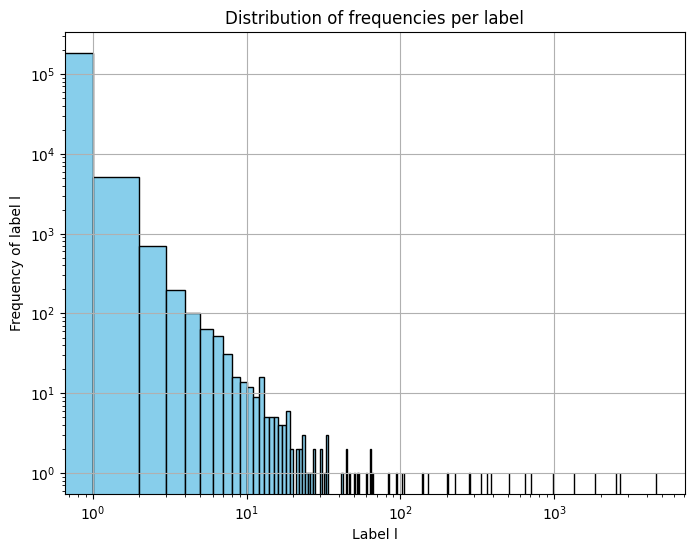

In [6]:
# Use histogram plot
plt.figure(figsize=(8, 6))
plt.hist(y, bins=range(0, max(y) + 2), color='skyblue', edgecolor='black')
plt.xlabel('Label l')
plt.ylabel('Frequency of label l')
plt.title('Distribution of frequencies per label')
plt.grid(True)
plt.xscale('log')  # Set x-axis scale to logarithmic
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.show()

From the plot we can clearly see that we are dealing with a heavily imbalanced dataset, since the distribution of the log frequencies of the labels is very skewed towards the 0. The label 0 is in fact more than 10 times more frequent than label 1 and successive ones.

Solving this problem with a regression approach is therefore very hard if not infeasible.

To reduce the imbalance, we are going to shift to a **BINARY CLASSIFICATION** problem, where we will compact all labels $l > 0$ under a new label $1$.

The new target $y$ will therefore be represented by the following set of discrete labels:
$$y =  \{0, 1\}$$

The meaning is the following:
- all reviews which have 0 votes are considered **not funny** (label $0$)
- all reviews which have more than 0 votes are considered **funny** (label $1$)

In [7]:
# Convert the labels
y = [0 if num == 0 else 1 for num in y]
y = np.array(y)

Now let's examine the new log frequency distribution of the labels.

In [8]:
def check_for_imbalance(X, y):
  """
        Compute frequency of samples per binary label.

        Parameters:
          - X (numpy array): The samples
          - y (numpy array): The labels

        Returns:
          - size_X_y0 (int): number of samples with label 0
          - size_X_y1 (int): number of samples with label 1
  """
  indices_y0 = np.where(y == 0)[0]
  size_X_y0 = len(indices_y0)

  #Indices where y equals 1
  indices_y1 = np.where(y != 0)[0]
  size_X_y1 = len(indices_y1)

  print("Size of X when y = 0:", size_X_y0)
  print("Size of X when y = 1:", size_X_y1)

  return size_X_y0, size_X_y1

Size of X when y = 0: 182691
Size of X when y = 1: 6401


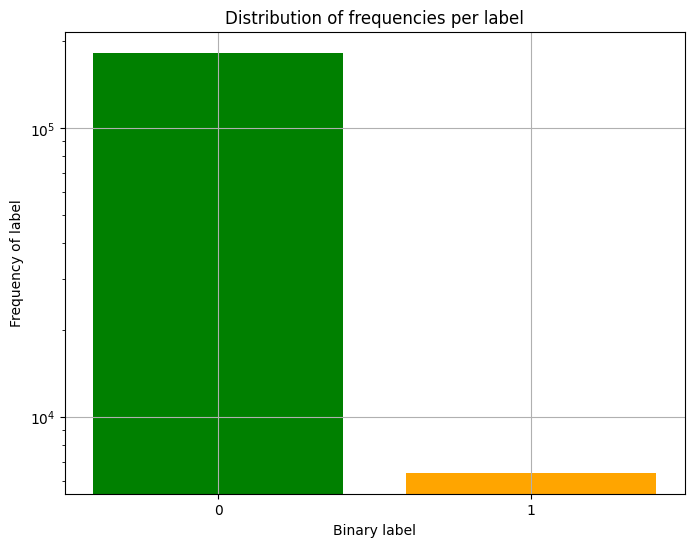

In [9]:
# Use histogram plot

# Count the frequency of each value in y
size_X_y0, size_X_y1 = check_for_imbalance(X, y)

# Define the labels for the bars
labels = ['0', '1']

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, [size_X_y0, size_X_y1], color=['green', 'orange'])
plt.xlabel('Binary label')
plt.ylabel('Frequency of label')
plt.title('Distribution of frequencies per label')
plt.grid(True)
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.show()

As expected, the distribution of the log frequency is still very imbalanced in favor of class $0$, therefore we need some strategy to balance out the dataset before proper learning can be achieved. This is because if we leave the dataset as it is, the best classifier in terms of accuracy is most likely going to be the naive classifier that always predicts the label $0$.

An objection may be raised considering the idea of training based on the F1 score instead of accuracy, which is better for imbalanced datasets, however here the imbalance is so large that our attempts still resulted in unsatisfying F1 score for the minority class (see Section "Our Model").

##Data rebalance

Our approach to deal with the imbalance is the simplest, that is, random **undersampling**. In particular, we are going to randomly drop samples from the majority class until the majority and minority classes have an equal amount of samples.

This induces a high loss of data, reducing the potential learning capability of our model, which is why **oversampling** could be a better alternative. However, we still need to keep in mind that to balance the dataset we need a very large amount of data, therefore by performing oversampling we will definitely introduce a lot of noise. NLP augmentation is in fact not as straightforward as Computer Vision augmentation, as changing a word is much more impactful than changing a pixel value. Additionally, if the task is to detect funny reviews, which is intrinsically very hard due to high inter-class variance and subjectivity, the results could directly influence the labels (unwanted behavior), as changing a word in a funny review with a synonym, or rephrasing it entirely, may result in the review not being funny anymore.

We therefore think that because oversampling in this case can cause our model to learn wrong representations for the labels, undersampling is the better approach, and thus it is the one we have chosen for implementation.

In [10]:
def balance_classes(X, y):
    """
        Undersample (X, y) by removing randomly samples from the majority class
        until they match the number of samples in the minority class.

        Parameters:
          - X (numpy array): The samples
          - y (numpy array): The labels

        Returns:
          - X[balanced_indices]: Rebalanced X
          - y[balanced_indices]: Rebalanced y
    """
    old_len = len(X)

    # Find indices of examples for each class
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]

    # Calculate the number of examples in each class
    num_class_0 = len(indices_class_0)
    num_class_1 = len(indices_class_1)

    # Randomly select a subset of examples from class 0 to match the number of examples in class 1
    if num_class_0 > num_class_1:
        # Randomly shuffle indices of class 0 examples
        np.random.shuffle(indices_class_0)
        # Keep only enough examples from class 0 to match the number of examples in class 1
        indices_class_0 = indices_class_0[:num_class_1]
    elif num_class_1 > num_class_0:
        # Randomly shuffle indices of class 1 examples
        np.random.shuffle(indices_class_1)
        # Keep only enough examples from class 1 to match the number of examples in class 0
        indices_class_1 = indices_class_1[:num_class_0]

    # Combine the balanced indices
    balanced_indices = np.concatenate([indices_class_0, indices_class_1])

    # Shuffle the combined indices
    np.random.shuffle(balanced_indices)

    new_len = len(balanced_indices)

    print(f"Dataset has been reduced by {(1-new_len/old_len):.2%} for class balancing")

    # Return the balanced subset of data
    return X[balanced_indices], y[balanced_indices]


Perform the balancing.

In [11]:
# Balance the dataset
check_for_imbalance(X, y)

X, y = balance_classes(X, y)

check_for_imbalance(X, y)

Size of X when y = 0: 182691
Size of X when y = 1: 6401
Dataset has been reduced by 93.23% for class balancing
Size of X when y = 0: 6401
Size of X when y = 1: 6401


(6401, 6401)

As we can see, the loss of data is very high, as the size of the new dataset is more than 10 times smaller than the original one.

However it is now balanced.

# Towards model building

Let us now proceed into the preparations steps to the model building.

In particular:
1.   Build the embedding layer for the neural model.
2.   Split the data into training, validation and test.




## Embedding layer

The following code and markdowns are based on our custom implementation of an example by Keras (https://keras.io/examples/nlp/pretrained_word_embeddings/)

First let's define the input length of a sequence to the embedding layer as the median length of the reviews. This is ensure that half of the sequences will be padded and half truncated, for equality.

In [96]:
# Calculate lengths of all sequences
sequence_lengths = [len(sequence) for sequence in X]

# Calculate the median length
sorted_lengths = sorted(sequence_lengths)
n = len(sorted_lengths)
if n % 2 == 0:
    median_length = (sorted_lengths[n // 2 - 1] + sorted_lengths[n // 2]) / 2
else:
    median_length = sorted_lengths[n // 2]

# Set the length of the sequences for the models
SEQUENCE_LENGTH = int(median_length)

print("Median length of sequences:", SEQUENCE_LENGTH)

Median length of sequences: 60


Build a TextVectorization layer to split text into sequences of words (tokens).

Build a vocabulary mapping indices to words.

Build an inverted dictionary mapping words of the vocabulary to their indices.



In [97]:
vectorizer = keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=SEQUENCE_LENGTH
    )
text_ds = tf_data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

We are going to use the **GloVe** pretrained embeddings for the words in order to have a good head-start in the learning phase and hopefully achieve faster convergence and better quality results.

NOTE: we have the 50d embeddings in the GitHub repository already, however, for better representations, since the computational power in the end allowed us to make use of more complex representations, we are going to use the 100d ones. Due to their high memory size, they could not be uploaded on GitHub, and therefore they have to be downloaded online, causing some unfortunate delay in the code execution...

Build a dictionary mapping each word (string) to their pretrained embedding representation (NumPy vector).

In [98]:
# Download the pretrained embeddings
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

# Use the 100d embeddings
path_to_glove_file = "glove.6B.100d.txt"

# Build pretrained embeddings dictionary
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

--2024-03-29 16:41:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2      100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-03-29 16:44:23 (5.19 MB/s) - ‘glove.6B.zip.2’ saved [862182613/862182613]

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Found 400000 word vectors.


Prepare a corresponding embedding matrix that we can use in a Keras Embedding layer, where the entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [99]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13794 words (5591 misses)


Notice that some words are missing their representation. In this case the embeddings will be learnt from scratch.

Build the embedding layer, with pretrained weights.

In [100]:
# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))

# Set pretrained weights
embedding_layer.set_weights([embedding_matrix])

## Data split

Split data into training, test and validation sets.

Ensure they contain the exact amount of samples for each class, using stratify function.

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED, stratify=y_train)

Check for correctness.

In [102]:
check_for_imbalance(X_train, y_train)

Size of X when y = 0: 4096
Size of X when y = 1: 4096


(4096, 4096)

First, convert our list-of-strings data into right-padded NumPy arrays of integer indices.



In [103]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val = vectorizer(np.array([[s] for s in X_val])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("Training sample 0:", X_train[0])
print("Shape of training set:", X_train.shape)
print("Validation sample 0:", X_val[0])
print("Shape of Validation set:", X_val.shape)
print("Test sample 0:", X_test[0])
print("Shape of Test set:", X_test.shape)

Training sample 0: [ 56 115  19 112 400  24   4  34 184  10   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Shape of training set: (8192, 60)
Validation sample 0: [550 440  64  34   7  38 440  11   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Shape of Validation set: (2049, 60)
Test sample 0: [  7 370  14   5   3  26  16  62 187  17  20 686   4   7  66  26  16 106
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Shape of Test set: (2561, 60)


As we can see a training / validation / test sample is a sequence of 60 indices, where each index refers to a word in the vocabulary and to a pretrained GloVe vector representation of the same word in the embedding matrix.

# Models Building

Now we get into the full model implementations.

## Baseline Model

For the baseline model we are going to use Gradient Boosting for classification.

"Gradient boosting is a machine learning ensemble technique that combines the predictions of multiple weak learners, typically decision trees, sequentially. It aims to improve overall predictive performance by optimizing the model’s weights based on the errors of previous iterations, gradually reducing prediction errors and enhancing the model’s accuracy."

(https://www.analyticsvidhya.com/blog/2021/09/gradient-boosting-algorithm-a-complete-guide-for-beginners/)

In [104]:
baseline_model = GradientBoostingClassifier()

## Our Model

Define our custom **hypermodel** for searching the best hyperparameters and training the best model for the task.

The **hyperparameters** chosen are the following:
- `model_name`: dictates the kind of model we are going to use (*LSTM*, *GRU*, *CNN*, *BiLSTM*)
- `units`: the number of units in each layer. The base value is fixed, and they may be used multiplied by a factor depending on the model and the depth. Notice that the choice is among small values, as the amount of data is limited (barely above 8000 training sequences).
- `dropout`: the dropout rate after *Dense* layers for regularization purpose.
- `learning_rate`: the learning rate for the Adam optimizer.

The loss function is given by the tuner.

All models share the same input format in the form of the vectorized sequences.

An embedding layer is tasked with feeding to the core functioning layers (*LSTM*, *BiLSTM*, *GRU*, *Conv1D*) the embedded sequences.

A final *Dense* layer with sigmoid activation is used to predict the class probabilities.

In [105]:
class HyperModelBuilderBinary(kt.HyperModel):
    def __init__(self, loss_function):
        self.loss_function = loss_function

    def build_lstm_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = LSTM(units=units, dropout=dropout, recurrent_dropout=dropout)(emb)
        x = Dense(units, activation="relu")(x)
        x = Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model

    def build_bidirectional_lstm_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = Bidirectional(LSTM(units=units, dropout=dropout,
                               recurrent_dropout=dropout))(emb)
        x = Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model


    def build_gru_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = GRU(units=units,  dropout=dropout, recurrent_dropout=dropout)(emb)
        x = Dense(units, activation="relu")(x)
        x = Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model

    def build_cnn_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = layers.Conv1D(units*3, 5, activation="relu", strides=1, padding="same")(emb)
        x = layers.MaxPooling1D(3)(x)
        x = layers.Conv1D(units*2, 3, activation="relu", strides=1, padding="same")(x)
        x = layers.MaxPooling1D(3)(x)
        x = layers.Conv1D(units, 3, activation="relu", strides=1, padding="same")(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        preds = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, preds)

        model.compile(optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss=self.loss_function,
            metrics=["accuracy"])

        model.summary()

        return model

    def build_model(self,hp):
        model_name = hp.Choice('model_name', values=['LSTM', 'GRU', 'CNN', 'BidirectionalLSTM'])
        dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.2)
        units = hp.Int('units', min_value=16, max_value=80, step=16)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        if model_name == 'LSTM':
            return self.build_lstm_model(dropout, units, learning_rate)
        elif model_name == 'BidirectionalLSTM':
            return self.build_bidirectional_lstm_model(dropout, units, learning_rate)
        elif model_name == 'GRU':
            return self.build_gru_model(dropout, units, learning_rate)
        elif model_name == 'CNN':
            return self.build_cnn_model(dropout, units, learning_rate)


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, random_state=SEED)

Define the loss function `loss` as Binary Cross Entropy. For the record, attempts were made to use a focal loss such as Binary Focal Cross Entropy on the imbalanced dataset. However, poor results were still obtained after assigning weights inversely proportional to the number of samples in each class, i.e., the F1 score of class $1$ was still 0, meaning we had performances comparable to the naive classifier.

Define the hypertuner object `tuner`, based on the **Bayesian Optimization** algorithm, which is able to overcome the limitations of random sampling based techniques by taking into account the history of the tried combinations, and then through a gaussian process estimate the next best hyperparameters.

Additionaly, as in the previous assignment, with this algorithm we are able to limit the number of trials `max_trials` to just 10 for faster execution.

In [106]:
# Loss function
loss = keras.losses.BinaryCrossentropy(
      from_logits=False,
      label_smoothing=0.0,
      axis=-1,
      reduction="sum_over_batch_size",
      name="binary_crossentropy",
)

# Initialize tuner
hypermodel_builder = HyperModelBuilderBinary(loss_function=loss)

tuner = kt.BayesianOptimization(hypermodel_builder.build_model,
                        objective='val_loss',
                        max_trials=10,
                        executions_per_trial=1, # The documentation says that makes things faster
                        overwrite=True,
                        max_consecutive_failed_trials=5,
                        directory='tuner_results',
                        project_name='classification_tuning')

# Summarize the search space
tuner.search_space_summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,938,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           7,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,946,477 (7.43 MB)

 Trainable params: 1,946,477 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

Search space summary
Default search space size: 4
model_name (Choice)
{'default': 'LSTM', 'conditions': [], 'values': ['LSTM', 'GRU', 'CNN', 'BidirectionalLSTM'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.2, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 80, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training

Now we move into the training part of the baseline and our model.

## Baseline's training

Here we train the baseline if specified, or we load the already trained model.

In [107]:
if TRAIN_BASELINE:
  baseline_model.fit(X_train, y_train)
  joblib.dump(baseline_model, '/content/DL_Ass3/models/baseline_model_cla.pkl')
else:
  baseline_model = joblib.load('/content/DL_Ass3/models/baseline_model_cla.pkl')

## Our model's training

Two operations will be performed:
- Searching for the best parameters (or loading the ones found offline).
- Training of the model with the best parameters (or loading the best model trained offline).

### Search
First of all let's search the best parameters for our model, if requested.

In [108]:
if SEARCH_PARAMETERS:
  # Early stop to prevent overfitting
  stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
  )

  # Perform hyperparameter search
  tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=BATCH_SIZE, callbacks=[stop_early])
  # Get the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  # Define the file name where you want to save the hyperparameters
  file_name = "/content/DL_Ass3/parameters/best_hps_cla.json"
  #Save the hp
  with open("/content/DL_Ass3/parameters/best_hps_cla.pkl", "wb") as f:
    pickle.dump(best_hps, f)

### Train
Here we load the best parameters found offline (equal to those online if the search has been performed), and either train the best model or load the weights of the already trained best model.

{'model_name': 'BidirectionalLSTM', 'dropout': 0.2, 'units': 80, 'learning_rate': 0.001}


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,938,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 160)                 │         115,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 80)                  │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,067,501 (7.89 MB)

 Trainable params: 2,067,501 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5406 - loss: 0.6882 - val_accuracy: 0.6144 - val_loss: 0.6388
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 697ms/step - accuracy: 0.6024 - loss: 0.6633 - val_accuracy: 0.6281 - val_loss: 0.6249
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 989ms/step - accuracy: 0.6248 - loss: 0.6441 - val_accuracy: 0.6388 - val_loss: 0.6250
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 854ms/step - accuracy: 0.6351 - loss: 0.6348 - val_accuracy: 0.6315 - val_loss: 0.6452
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 877ms/step - accuracy: 0.6604 - loss: 0.6184 - val_accuracy: 0.6413 - val_loss: 0.6188
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 534ms/step - accuracy: 0.6683 - loss: 0.6103 - val_accuracy: 0.6515 - val_loss: 0.6304
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 829ms/step - accuracy: 0.6904 - loss: 0.5918 - val_accuracy: 0.6471 - val_loss: 0.6463
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 712ms/step - accuracy: 0.7036 - loss: 0.5759 - val_accurac

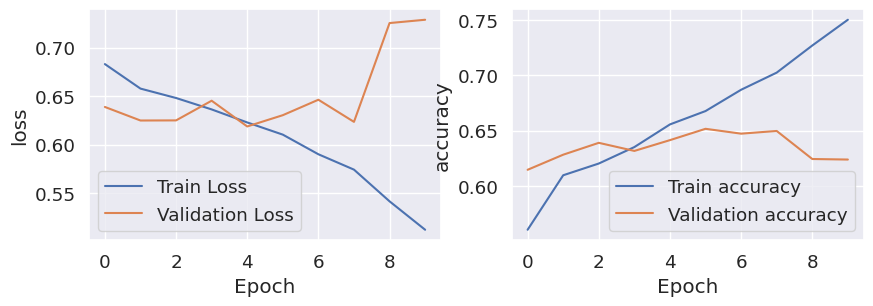

In [111]:
# Read the best parameters
with open("/content/DL_Ass3/parameters/best_hps_cla.pkl", "rb") as f:
  best_hps = pickle.load(f)
  print(best_hps.values)

# Build the model
best_model = tuner.hypermodel.build(best_hps)

if TRAIN_MODEL:
  # Early stop to prevent overfitting
  stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=3,
  )

  # Fit the model
  history = best_model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[stop_early])
  # Save the model
  best_model.save_weights('/content/DL_Ass3/models/best_model_cla.weights.h5')
  plot_history(history)

else:
  # Load model
  best_model.load_weights('/content/DL_Ass3/models/best_model_cla.weights.h5')


From the training curve of the losses and accuracies, we can clearly see that we have overfitting occurring, despite having relatively low complexity-wise models. This is expected due to the limited amount of data we are working on and due to the high complexity of the task. We most likely have high inter-class variance that causes the model to not generalize well on what makes a review funny or not (in terms of semantics and structure of the sequences) as training and validation sets may differ quite substantially since small.

# Evaluation

Now we move in the final evaluation part of the notebook, where we will examine the results and compare the two models, trying to highlight what went wrong and how to improve.

## Helper functions

Let's define some helper functions first.

###Confusion Matrix
If label $0$ is the *negative* and label $1$ is the *positive*, then the matrix is structured as follows:
- top left -> TN (True Negatives)
- top right -> FN (False Negatives)
- bottom left -> FP (False Positives)
- bottom right -> TP (True Positives)

The normalization affects the rows, meaning it's going to display the proportions with respect to the total number of positives (2nd row) or negatives (1st row).
Notice in particular that the normalized values on the main diagonal represent the recall for each class, by definition.

In [112]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, cmap='Blues'):
    """
    Plot the confusion matrix.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
    - cmap (str, optional): Colormap for the heatmap. Defaults to 'Blues'.

    Returns:
    - None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Check if normalization is requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

### Precision-recall curve

The precision-recall curve is useful for evaluating the performance of a model.
It is constructed by calculating and plotting the precision against the recall at different recall cut-off values.

In [113]:
def plot_precision_recall_curve(y_true, y_scores):
    """
    Plot the Precision-Recall curve and compute the area under the curve (AP).

    Parameters:
    - y_true: Array of true labels (binary: 0 or 1)
    - y_scores: Array of predicted probabilities for the positive class

    Returns:
    - None
    """
    # Compute precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Compute average precision (area under the precision-recall curve)
    average_precision = average_precision_score(y_true, y_scores)

    # Plot Precision-Recall curve
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()

## Baseline evaluation

Compute accuracy, precision, recall, and F1 score for the baseline.

In [121]:
y_pred = baseline_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
  # Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.5829754002342835
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1281
           1       0.57      0.64      0.60      1280

    accuracy                           0.58      2561
   macro avg       0.58      0.58      0.58      2561
weighted avg       0.58      0.58      0.58      2561



Overall, the accuracy of the baseline on the test set is low, as expected due to the limited amount of data: the model gains only 10% accuracy over the naive classifier.

By looking at the precision and recall values, we can see the following:
- Class 0: higher precision, lower recall: the model is more picky on this class, meaning less samples are classified but most are correct.
- Class 1: lower precision, higher recall: as a result of being more picky on class 0, it is going to be predicting most of the samples to be of class 1, inducing most of the samples of this class to be found, but also many of these predictions to be wrong.

However we can also notice how the values do not change very much with the different classes, indicating that predictions are overall balanced, but still not good.

Let us now plot the normalized confusion matrix.

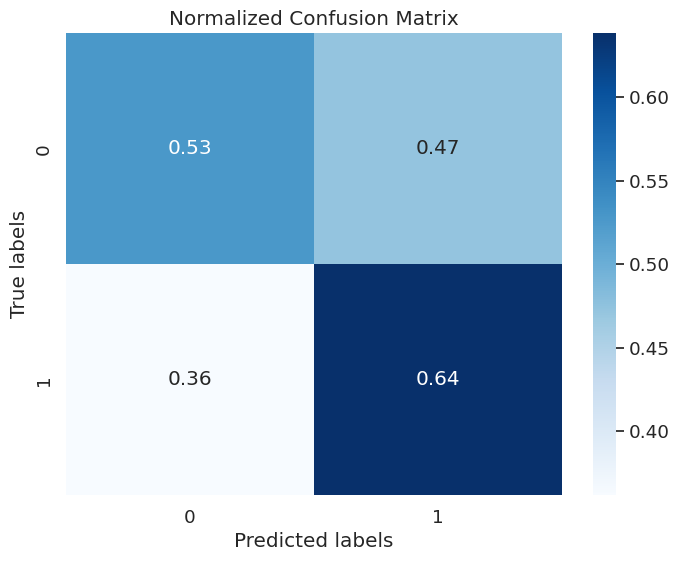

In [115]:
plot_confusion_matrix(y_test, y_pred, normalize=True)

The ideal plot will have 1s on the main diagonal (Correct predictions) and 0s in the other two squares (Wrong predictions).
In the worst case we will have 0.5 on all entries.

Our case is somewhat in the middle:

- Higher confusion for class 0, as the recall is close to 0.50 (a bit more than half samples are classified correctly)
- Lower confusion, but still not optimal for class 1, as the recall is 0.67 (2/3 of the samples of the class have been correctly classified).

Let us now plot the precision-recall curve

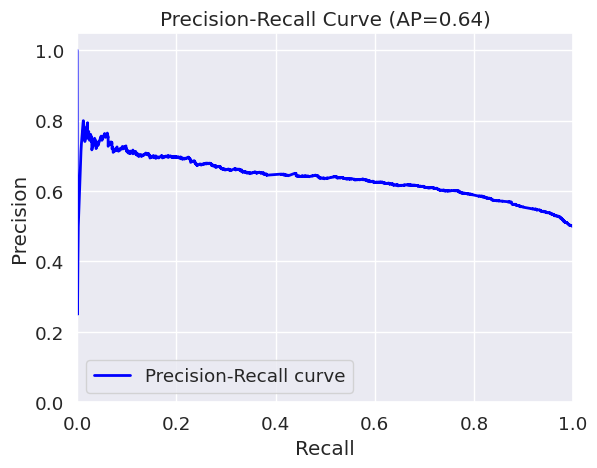

In [118]:
plot_precision_recall_curve(y_test, y_pred)

Based on the following illustration, the baseline model performs slightly better than the naive classifier.

(https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248)

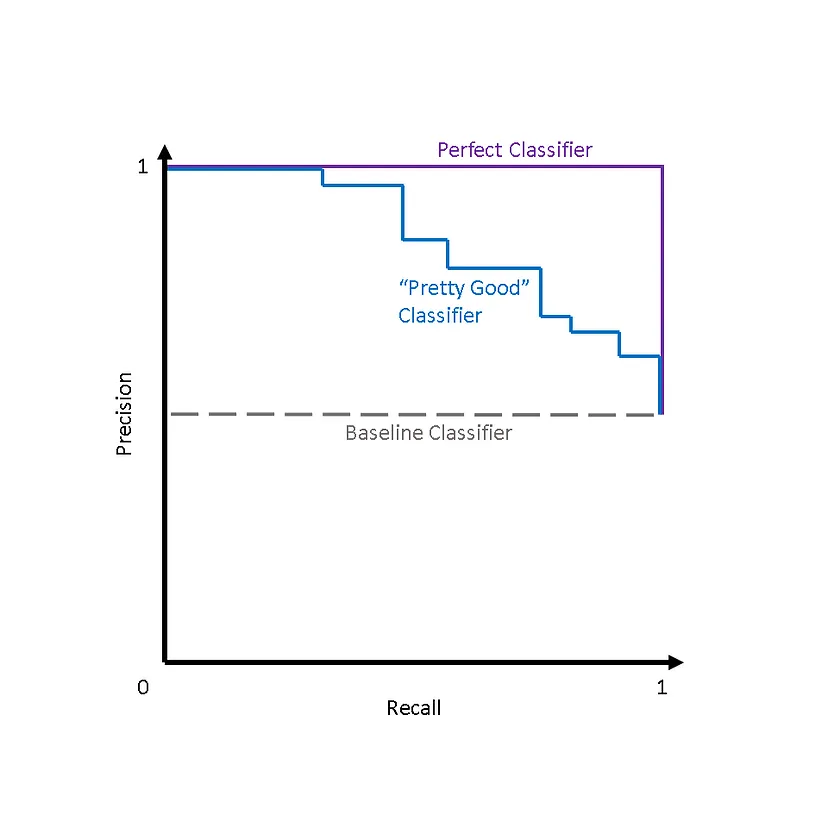

## Our model's evaluation

Compute accuracy, precision, recall, and F1 score for our model.

In [126]:
y_pred = best_model.predict(X_test)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
y_pred_binary=np.squeeze(y_pred_binary)
accuracy_best = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy_best)
  # Print the classification report
print(classification_report(y_test, y_pred_binary))
print(f"Accuracy improvement over the baseline: {(accuracy_best-accuracy)*100:.2f}%")

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Accuracy: 0.6208512299882858
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1281
           1       0.63      0.59      0.61      1280

    accuracy                           0.62      2561
   macro avg       0.62      0.62      0.62      2561
weighted avg       0.62      0.62      0.62      2561

Accuracy improvement over the baseline: 3.79%


Overall, the accuracy of our model on the test set is still quite low, again as expected due to the limited amount of data: the model gains only 3.79% accuracy over the baseline, which is underwhelming.

By looking at the precision and recall values, we can see the opposite behavior occurring, with respect to the baseline:
- Class 1: higher precision, lower recall: the model is more picky on this class, meaning less samples are classified but most are correct.
- Class 0: lower precision, higher recall: as a result of being more picky on class 0, it is going to be predicting most of the samples to be of class 1.

Again, though, values are not so different among the different classes, indicating that predictions are overall balanced, but still not good enough.

Let us now plot the normalized confusion matrix.

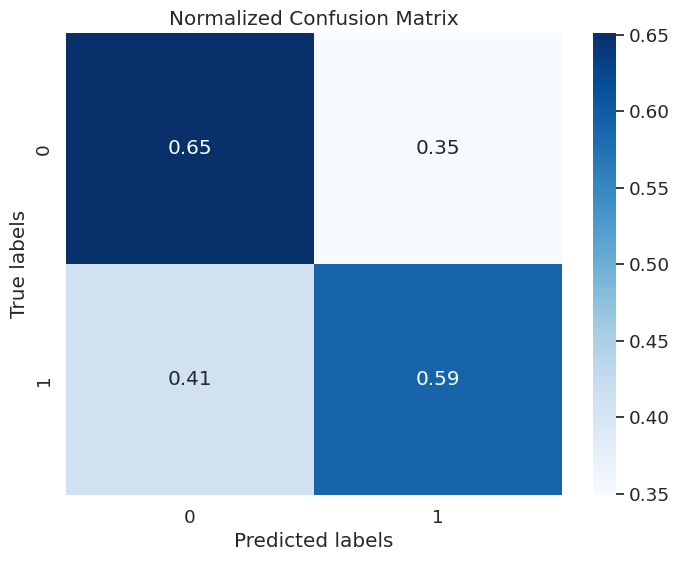

In [128]:
plot_confusion_matrix(y_test, y_pred_binary, normalize=True)

Again, our case is somewhat in the middle between the ideal and worst case:

- Higher confusion for class 1, as the recall is closer to 0.50 (a bit more than half samples are classified correctly)
- Lower confusion, but still not optimal for class 0, as the recall is 0.65 (2/3 of the samples of the class have been correctly classified).

Let us now plot the precision-recall curve

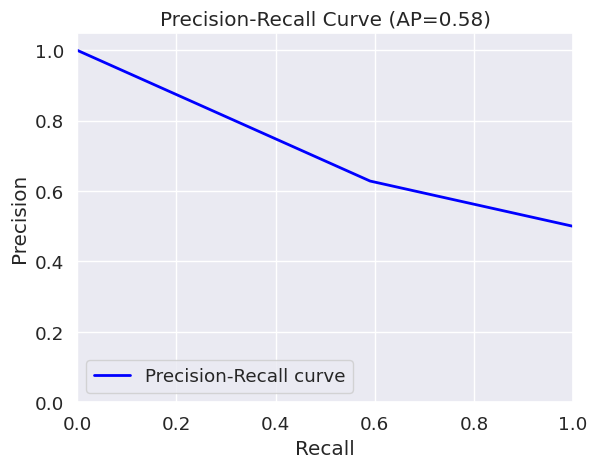

In [129]:
plot_precision_recall_curve(y_test, y_pred_binary)

We can still see some improvement over the baseline on the shape of the curve, however it is still quite sub-optimal.

# Possible improvements



First of all, as we have written before, the **imbalance** in the data distribution is a big issue. Since the task is hard, we need more samples for the funny class, which can only be gathered from actual users if we pursue reliability, as humor is something only humans can tell. Once more data is gathered, more complex models may be employed. In fact, our attempts on using more complex models on this limited data resulted in even stronger overfitting, as predictable.

Second of all, the structure of the **sequences** may also play a part in the model's failure. If we plot the log frequences per review length, per class, we can clearly see two things:
1. the distribution of the log frequences overlap in the two classes, meaning that the lengths of the reviews do not influence the labels.
2. most reviews are short. By taking the median we ensure a balanced sequence length, as half sequences will be padded and half will be truncated. However by cutting away excessively long reviews we can hypothetically still preserve most of the information while further reducing the median, and thus the input lengths to the embedding layer of the model, inducing even faster computation and more accurate learning.


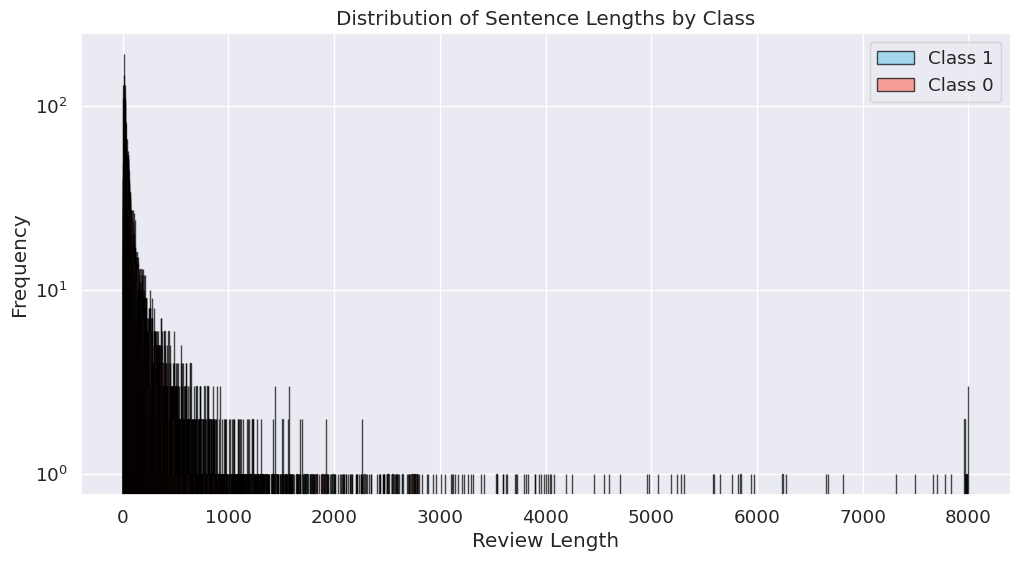

In [131]:
# Filter sentence lengths for class 1
class_1_lengths = [len(sentence) for i, sentence in enumerate(X) if y[i] == 1]

# Filter sentence lengths for class 0
class_0_lengths = [len(sentence) for i, sentence in enumerate(X) if y[i] == 0]

# Plot histograms for both classes
plt.figure(figsize=(12, 6))

# Plot histogram for class 1
plt.hist(class_1_lengths, bins=range(1, max(class_1_lengths) + 2), color='skyblue', edgecolor='black', alpha=0.7, label='Class 1')

# Plot histogram for class 0
plt.hist(class_0_lengths, bins=range(1, max(class_0_lengths) + 2), color='salmon', edgecolor='black', alpha=0.7, label='Class 0')

plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths by Class')
plt.grid(True)
plt.legend()
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.show()



Only once we'll have more data, a more complex model and better sentence structures may we obtain the best model.